In [1]:
# Fit Forward, 10 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 10

In [8]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, nobad, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    
    if len(primary_river.iloc[spoint-8:spoint]) != 8:
        print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        nobad = nobad + 1
        allbad = True
    else:
        allbad = False
        for ii in range(1, 8):
            jj = ii + gap_length - 1        
            persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
            if ii > 1:
                b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
                linear[ii-2] = b + m * jj
            if ii > 2:
                b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
                cubic[ii-3] = b + m * jj + c * jj**2

        if fittype == 'fit':
            useriver = matching_dictionary[river]
        elif fittype == 'backup':
            useriver = backup_dictionary[river]
        firstchoice = read_river(useriver, 'primary')
        for jj, length in enumerate(fitlength):
            for ii in range(length):
                denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
                if len(denom) == 1:
                    ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                                firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
                else:
                    bad = True
            if not bad:
                numer = firstchoice[firstchoice.index == primary_river.index[point]].values
                if len(numer) != 1:
                    print ('Numer catch')
                    bad = True
                else:
                    fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
        if bad:
            fittedbad = fittedbad + 1
        if doplots:
            ax.plot(persist)
            ax.plot(range(1, 7), linear)
            ax.plot(range(2, 7), cubic)
            if not bad:
                ax.plot(fitted)
            ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
            ax.plot(7, primary_river.iloc[spoint].values, 'x')
            ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
            ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad, allbad, nobad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [12]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, nobad, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad, allbad, nobad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, nobad, doplots)

    if not allbad:
        GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
        accumulateG += GG
        accumulateC += CC
        accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad, nobad

In [13]:
print (gap_length)

10


In [14]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
Numer catch
Numer catch
Numer catch
Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  942.  942.  942.  942.] [  96.86216269   96.12947753   95.83316298   95.92394114   95.77102748
   95.55727128   95.57558062  342.40940215  306.75344607  270.50594906
  246.02692464  223.66629976  208.14918098 2088.32618861 1549.8728115
 1219.01668308 1033.88945598  896.22920522   63.21199196   64.09367434
   67.14713382   70.53427487] [0.128      0.134      0.139      0.14       0.145      0.146
 0.147      0.517      0.514      0.48       0.47       0.448
 0.411      0.797      0.756      0.749      0.749      0.731
 0.06475584 0.0552017  0.0552017  0.05732484] [0.         0.         0.         0.         0.         0.
 0.         0.23       0.206      0.182      0.179      0.169
 0.147      0.486      0.444      0.412      0.398      0.387
 0.00106157 0.00212314 0.00106157 0.        ]


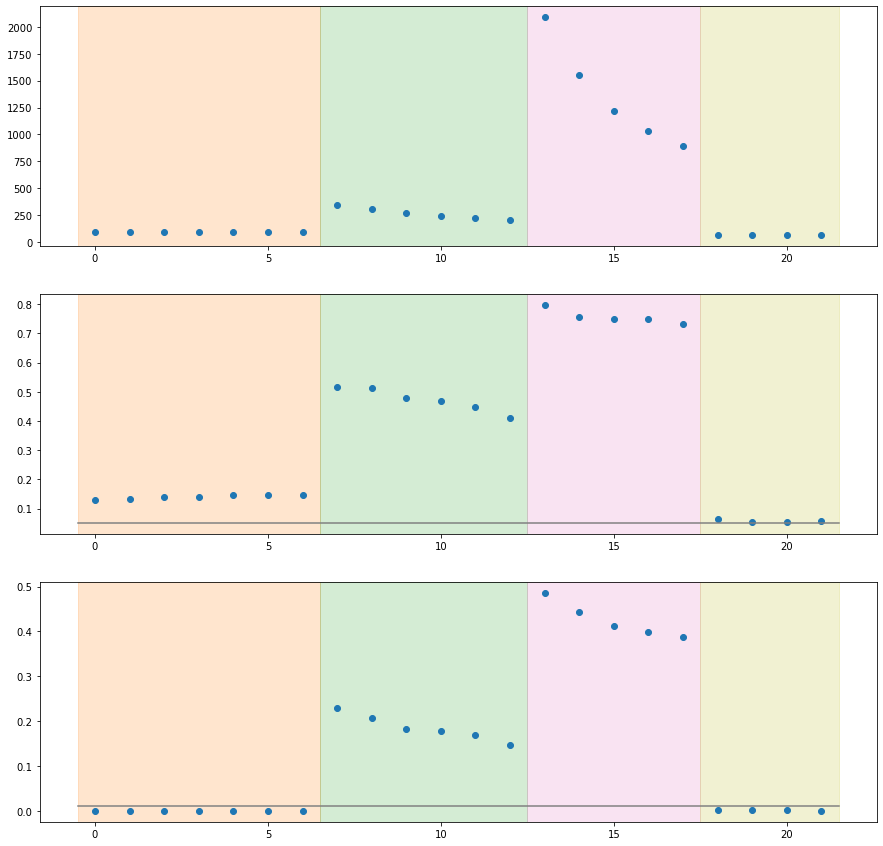

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [16]:
print (gap_length)

10


In [17]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


0 Primary River Flow    149.2295
Name: 1970-01-01 00:00:00, dtype: float64
realized 999
[999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.
 999. 999. 999. 999. 997. 997. 997. 997.] [ 158.30148212  157.55808822  155.51097916  152.54037508  149.51401707
  146.98522733  144.81296899  590.41783674  509.33610617  460.5736626
  416.12604306  379.94960726  356.17962018 3725.64671104 2745.82302997
 2065.14161918 1714.0714389  1420.24632056   78.50174335   77.99946213
   78.67517806   80.22089662] [0.25825826 0.24624625 0.24224224 0.23623624 0.23723724 0.24024024
 0.23823824 0.67267267 0.64364364 0.62962963 0.5995996  0.58058058
 0.56356356 0.81881882 0.81481481 0.7967968  0.77477477 0.78478478
 0.06519559 0.0551655  0.0551655  0.06218656] [0.         0.         0.         0.         0.         0.
 0.         0.31931932 0.28728729 0.26726727 0.22822823 0.20520521
 0.1991992  0.47247247 0.43143143 0.40640641 0.39239239 0.38638639
 0.00300903 0.00300903 0.         0.        ]


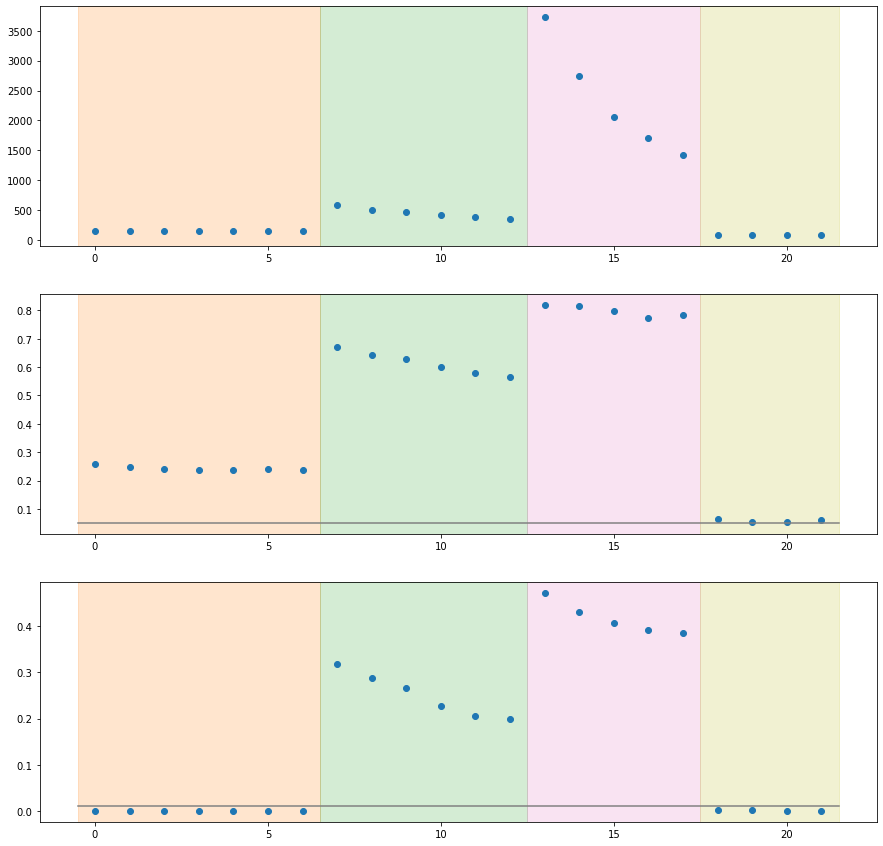

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [19]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  992.  992.  992.  992.] [ 155.4309099   153.67158875  153.29289953  152.8494815   153.05660622
  152.88905448  153.10893414  614.2479857   504.07390387  441.85769964
  408.43347514  371.18493949  343.23892654 4083.1325153  2784.74391803
 2084.96140568 1717.48905877 1451.58890276  160.89951631  165.06961398
  171.49310886  178.19690486] [0.082      0.078      0.075      0.073      0.077      0.075
 0.074      0.57       0.506      0.452      0.439      0.412
 0.381      0.9        0.85       0.815      0.796      0.77
 0.06854839 0.07258065 0.07459677 0.08568548] [0.         0.         0.         0.         0.         0.
 0.         0.283      0.24       0.204      0.192      0.171
 0.146      0.579      0.523      0.473      0.452      0.415
 0.00302419 0.00403226 0.00403226 0.00403226]


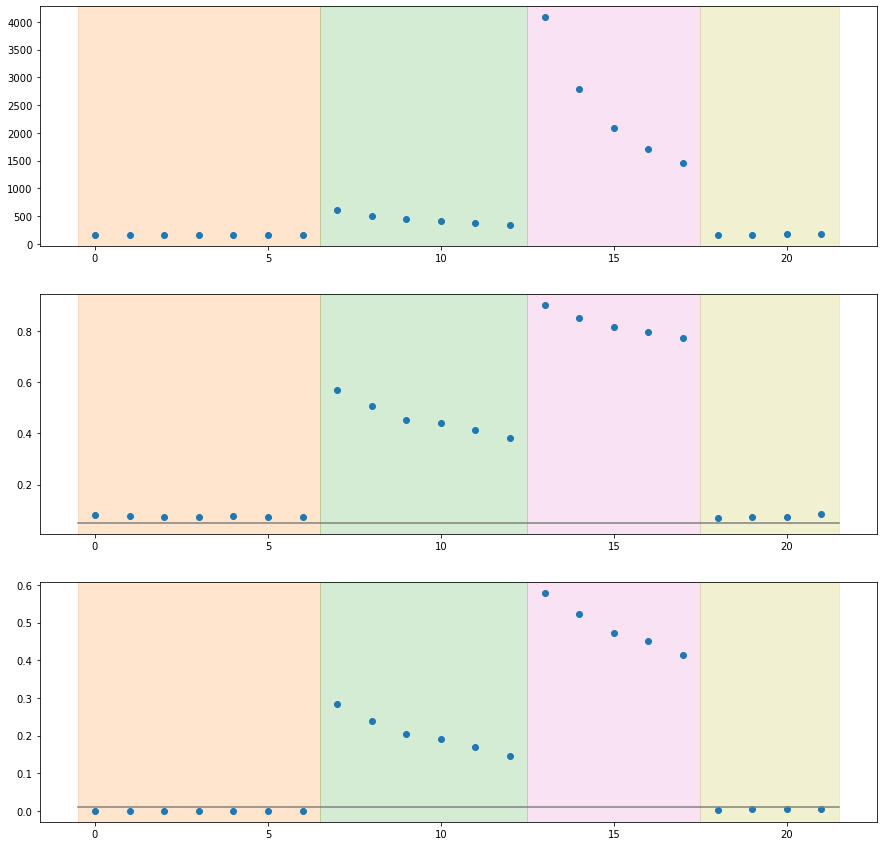

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [21]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


0 Primary River Flow    1.755642
Name: 1970-01-06 00:00:00, dtype: float64
0 Primary River Flow    1.699008
Name: 1970-01-08 00:00:00, dtype: float64
realized 998
[998. 998. 998. 998. 998. 998. 998. 998. 998. 998. 998. 998. 998. 998.
 998. 998. 998. 998. 999. 999. 999. 999.] [ 2.60624075  2.67531045  2.71623552  2.78071038  2.81054106  2.81260345
  2.80899527  7.33259869  6.47774824  6.37409571  5.68941686  5.29441672
  5.11037754 42.52571616 33.68402932 27.2943273  23.66085327 21.3314319
  1.40705747  1.41439203  1.45376339  1.49721117] [0.1503006  0.14529058 0.1503006  0.1492986  0.15831663 0.16633267
 0.17034068 0.42284569 0.40581162 0.39779559 0.38977956 0.38877756
 0.37775551 0.71943888 0.66633267 0.61523046 0.59318637 0.57915832
 0.05705706 0.05605606 0.05905906 0.06006006] [0.         0.         0.         0.         0.         0.
 0.         0.15330661 0.13627255 0.12224449 0.11923848 0.1242485
 0.10721443 0.34168337 0.31362725 0.29158317 0.26052104 0.25951904
 0.00600601 0.003

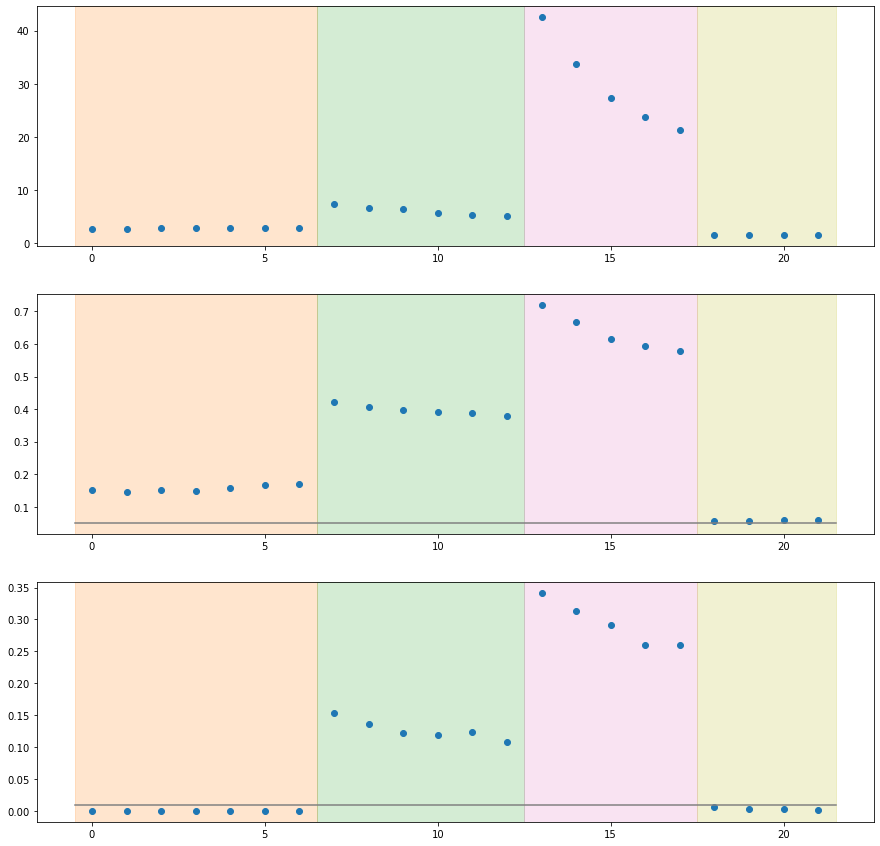

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');